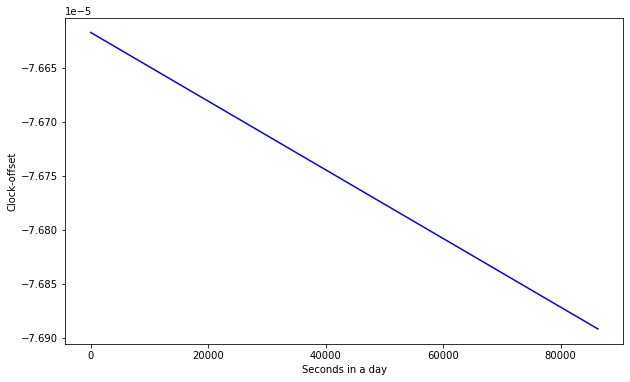

In [1]:
# Import all the required libraries and external script containing the functions

import math
import numpy as np
import matplotlib.pyplot as plt
import functions as fn

# Load Almanac of satellite SVN 63, PRN 01 (Block IIR) for 2016

# 2) Create a list containing all the epochs
t_start=0
t_end=(24*60*60)
t_step=30
t = list(range(t_start, t_end, t_step))
'''
1) Compute clock offsets and plot it
'''
# Tip: use a loop on t and append the elements to a list
clock_offsets = []
dt0=-7.661711424589*(10**(-5))
dt1=-3.183231456205*(10**(-12))
dt2=0
for x in t:
    dtx=dt0+(dt1*(x-t_start))+((dt2**(2))*((x-t_start)**2))
    clock_offsets=np.append(clock_offsets,dtx)
# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set(xlabel='Seconds in a day', ylabel='Clock-offset', )
ax.plot(t, clock_offsets, '-', color='blue')

In [38]:
#2) Compute the position of the satellite in Cartesian ITRF [X, Y, Z]

nepo=len(t)
coord_ORS=np.zeros((3,nepo))
coord_ITRF=np.zeros((3,nepo))
sqrta= 5.153650835037*(10**(3)) 
a=sqrta**(2)
e=3.841053112410*(10**(-3))
M0= 1.295004883409
Omega0= -2.241692424630*(10**(-1)) 
Omegadot= -8.386063598924*(10**(-9))

i0= 9.634782624741*(10**(-1)) 
idot= -7.286017777600*(10**(-11))  
w0= 9.419793734505*(10**(-1)) 
wdot= 0.0  

GMe = 3.986005*(10**(14))
OmegaEdot = 7.2921151467*(10**(-5))

n=math.sqrt(GMe/(sqrta**(6)))
count=0
for Dt in range(0,t_end,t_step):
	# Compute psi
    Mt=M0+(n*Dt)
    etat=fn.eccAnomaly(Mt,e)
    psit=math.atan(((math.sqrt(1-(e**2)))*(math.sin(etat)))/((math.cos(etat))-e))
	# Compute radius r
    rt=(a*(1-(e**(2))))/(1+(e*(math.cos(psit))))
	# Compute the coordinates of the satellite in ORS and store it in coord_ORS
    xORS=rt*(math.cos(psit))
    yORS=rt*(math.sin(psit))
    zORS = 0
    coord_ORS[0,count]=xORS
    coord_ORS[1,count]=yORS
    temp=np.array([[xORS],[yORS],[zORS]])
    # Compute rotation angles omega, i, OMEGA
    omega=w0+(wdot*Dt)
    i=i0+(idot*Dt)
    OMEGA=Omega0+((Omegadot-OmegaEdot)*Dt)
    # Compute the rotation matrices required to transform from ORS to ITRF
    # R(-omega(t))
    Romega=np.array([[math.cos(omega),-math.sin(omega),0],[math.sin(omega),math.cos(omega),0],[0,0,1]])
    # R(-i(t))
    Ri=np.array([[1,0,0],[0,math.cos(i),-math.sin(i)],[0,math.sin(i),math.cos(i)]])
    # R(OMEGA(t))
    RO=np.array([[math.cos(OMEGA),-math.sin(OMEGA),0],[math.sin(OMEGA),math.cos(OMEGA),0],[0,0,1]])
    # Final rotation matrix R
    R = np.dot(np.dot(RO, Ri), Romega)
    # Compute the coordinates of the satellites in ITRF and store it in coord_ORS
    ITRFt=np.dot(R,temp)
    coord_ITRF[0,count]=ITRFt[0,0]
    coord_ITRF[1,count]=ITRFt[1,0]
    coord_ITRF[2,count]=ITRFt[2,0]
    count=count+1
'''
3) Convert satellite's coordinates from global cartesian [X, Y, Z] to godetic [latitude, longitude, height]
'''
temp=np.array([[0],[0],[0]])
count=0
lat=[]
long=[]
height=[]
r = []
for i in range(len(t)):
    x=coord_ITRF[0,i]
    y=coord_ITRF[1,i]
    z=coord_ITRF[2,i]
    xyz = np.array([[x], [y], [z]])
# Tip: You can use the cartToGeod function provided
    coord_geod=fn.cartToGeod(xyz)
#radius
    rad=math.sqrt((x**(2))+(y**(2))+(z**(2)))
# Create 3 lists containing the values of Latitude, Longitude and Height
    lat.append(coord_geod[0,0])
    long.append(coord_geod[1,0])
    height.append(coord_geod[2,0])
    r.append(rad)
rmean=np.mean(r)


In [39]:
'''
4) Plot satellite's daily trajectory with basemap
'''
# EXAMPLE OF PLOTTING THE GROUNDTRACK
# REQUIRED LIBRARIES FOR THIS SOLUTION: pandas and geopandas
import pandas as pd
import geopandas as gpd

# Realize a dataframe containing satellite coordinates
df = pd.DataFrame()
df['time'] = t
df['Latitude'] = lat
df['Longitude'] = long
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = 3857)
world = gpd.read_file('world.shp')

<AxesSubplot:title={'center':'Satellite daily trajectory'}, xlabel='Longitude', ylabel='Latitude'>

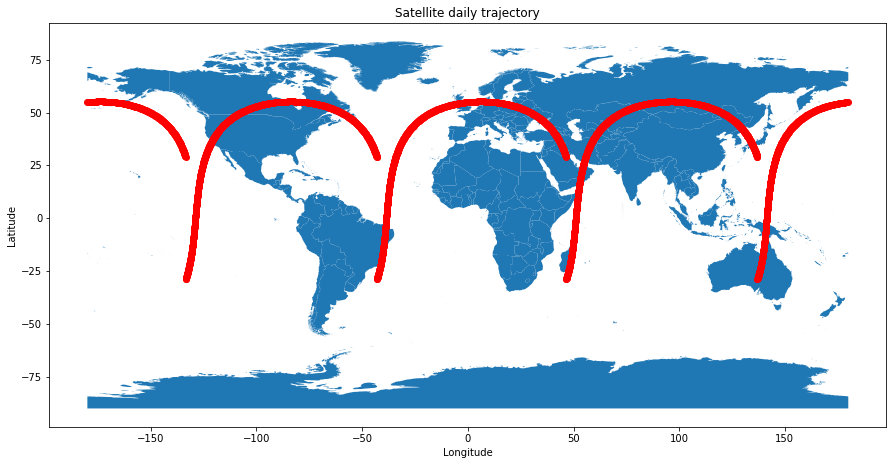

In [40]:
fig, ax = plt.subplots (figsize = (15,15))
world.plot(ax=ax)
ax.set(xlabel='Longitude', ylabel='Latitude', title='Satellite daily trajectory')
gdf.plot(ax = ax, marker='o', color='red')